In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
data = pickle.load(open(os.path.join(os.getcwd(), 'train_data.pickle'),'rb'))
print(data[0])
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]

[array([[192., 191., 190., ..., 188., 190., 189.],
       [192., 188., 190., ..., 186., 188., 187.],
       [187., 191., 189., ..., 186., 188., 186.],
       ...,
       [123., 132., 140., ..., 161., 162., 163.],
       [ 76., 123., 125., ..., 165., 165., 163.],
       [104., 109., 115., ..., 165., 166., 159.]], dtype=float32), array([0, 1, 0, 0, 0])]


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.maxpool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.maxpool2 = nn.MaxPool2d(3, 3)
        self.flatten_shape = None
        x = torch.randn([50,50]).view(-1,1,50,50)
        x = self.conv(x)
        self.fc1 = nn.Linear(self.flatten_shape, 128)
        self.fc2 = nn.Linear(128, 5)
    
    def conv(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        if self.flatten_shape is None:
            self.flatten_shape = x.shape[1] * x.shape[2] * x.shape[3]
            print(x.shape)
            print(self.flatten_shape)
        return x
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flatten_shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
#         x = self.fc2(x)
        return x
    
    
model = Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters())
EPOCHS = 64
        
    

torch.Size([1, 8, 4, 4])
128


In [5]:
class ImageData(Dataset):
    def __init__(self, data):
        self.x = torch.Tensor([i[0].astype(np.float32)/255.0 for i in data])
        self.y = torch.Tensor([i[1] for i in data])#.long()
        self.m = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.m
    

dataset_train = ImageData(data_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [6]:
def train(dataloader, model, loss_function, optimizer, EPOCHS):
    model.train()
    losses = []
    for epoch in range(EPOCHS):
        epoch_losses = []
        for i, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs = inputs.view(-1, 1, 50, 50).to(device)
            
            labels = labels.view(-1,5).to(device)   
#             print(labels)
            model.zero_grad()
            optimizer.zero_grad()
            y_hat = model.forward(inputs)
#             print(y_hat)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss)
            if i % 16 == 0:
                losses.append(loss)
        print(np.min(epoch_losses))
    return model, losses    

In [7]:
model, losses = train(dataloader_train, model, criterion, optimizer, EPOCHS)
torch.save(model.sta)

7it [00:01,  6.23it/s]
7it [00:00, 100.27it/s]
7it [00:00, 103.22it/s]
0it [00:00, ?it/s]

tensor(0.7577, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7579, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7575, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 94.84it/s]
7it [00:00, 101.72it/s]
7it [00:00, 96.15it/s]
0it [00:00, ?it/s]

tensor(0.7569, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7567, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7565, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 103.22it/s]
7it [00:00, 98.85it/s]
7it [00:00, 100.27it/s]
0it [00:00, ?it/s]

tensor(0.7550, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7557, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7545, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 98.86it/s]
7it [00:00, 97.48it/s]
7it [00:00, 96.61it/s]
0it [00:00, ?it/s]

tensor(0.7537, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7540, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7534, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 91.16it/s]
7it [00:00, 82.58it/s]
7it [00:00, 101.72it/s]
0it [00:00, ?it/s]

tensor(0.7524, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7514, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7474, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 86.65it/s]
7it [00:00, 103.22it/s]
7it [00:00, 103.22it/s]
0it [00:00, ?it/s]

tensor(0.7490, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7458, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7438, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 96.15it/s]
7it [00:00, 96.15it/s]
7it [00:00, 100.27it/s]
0it [00:00, ?it/s]

tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7302, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 98.86it/s]
7it [00:00, 93.60it/s]
7it [00:00, 100.27it/s]
0it [00:00, ?it/s]

tensor(0.7355, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7290, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 92.35it/s]
7it [00:00, 81.61it/s]
7it [00:00, 96.15it/s]
0it [00:00, ?it/s]

tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7110, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 52.38it/s]
7it [00:00, 67.49it/s]
0it [00:00, ?it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 71.62it/s]
7it [00:00, 63.23it/s]
0it [00:00, ?it/s]

tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 71.62it/s]
7it [00:00, 86.65it/s]
7it [00:00, 85.59it/s]
0it [00:00, ?it/s]

tensor(0.7097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 83.56it/s]
7it [00:00, 96.15it/s]
7it [00:00, 93.58it/s]
0it [00:00, ?it/s]

tensor(0.7047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 98.86it/s]
7it [00:00, 100.27it/s]
7it [00:00, 101.72it/s]
0it [00:00, ?it/s]

tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7014, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 104.76it/s]
7it [00:00, 106.35it/s]
7it [00:00, 104.76it/s]
0it [00:00, ?it/s]

tensor(0.7018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6850, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 107.98it/s]
7it [00:00, 104.76it/s]
7it [00:00, 104.76it/s]
0it [00:00, ?it/s]

tensor(0.6926, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6872, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 103.22it/s]
7it [00:00, 103.22it/s]
7it [00:00, 101.72it/s]
0it [00:00, ?it/s]

tensor(0.6820, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6855, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6844, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 97.48it/s]
7it [00:00, 106.35it/s]
7it [00:00, 104.76it/s]
0it [00:00, ?it/s]

tensor(0.6805, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6854, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 68.14it/s]
7it [00:00, 62.67it/s]
0it [00:00, ?it/s]

tensor(0.6870, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 71.62it/s]
7it [00:00, 83.56it/s]
7it [00:00, 88.84it/s]
0it [00:00, ?it/s]

tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6818, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 86.65it/s]
7it [00:00, 93.58it/s]
7it [00:00, 100.27it/s]
0it [00:00, ?it/s]

tensor(0.6748, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6685, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6801, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 93.58it/s]
7it [00:00, 107.98it/s]
7it [00:00, 104.76it/s]
0it [00:00, ?it/s]

tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6609, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6673, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


7it [00:00, 100.27it/s]

tensor(0.6685, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


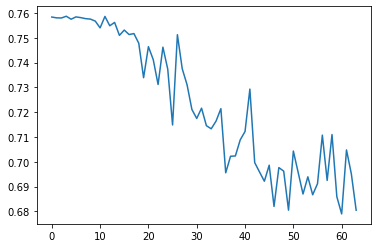

In [8]:
plt.plot(losses)

In [9]:
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.view(-1, 1, 50, 50).to(device)    
        labels = labels.view(-1,5).to(device)  
        
        y_hat = model.forward(inputs)
#         print(torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1)))
#         print(torch.argmax(labels, dim=1))
#         break
        correct += torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1))
#         print(correct)
        total += inputs.shape[0]
#         print(total)
    print(correct.item()/total)
dataset_val = ImageData(data_test)
dataloader_val = DataLoader(dataset_val, batch_size=32)
validate(model, dataloader_val)

2it [00:00, 182.31it/s]

0.6415094339622641
